In [2]:
import spacy
import networkx as nx

import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

/tmp/ipykernel_9372/2892709755.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [10]:
nlp = spacy.load("en_core_web_trf")

def find_noun_for_pronoun(token):
    for ancestor in token.ancestors:
        if ancestor.pos_ == 'NOUN':
            return ancestor
    return None

def get_entities(sentences):
    if isinstance(sentences, str):
        sentences = [sentences]
    entities = {}
    for i in range(len(sentences)):
        doc = nlp(sentences[i])

        for token in doc:
            temp = find_noun_for_pronoun(token)

            token_head_l = token.head.lemma_.lower()
            token_l = token.lemma_.lower()
            
            if token.dep_ in ['nsubj', 'nsubjpass'] and token.head.pos_ in ['VERB']:
                if temp:
                    token_l = temp.lemma_.lower()

                if token_head_l in entities.keys():
                    entities[token_head_l] = {**entities[token_head_l],**{token_l : token.dep_}}
                else:    
                    entities[token_head_l] = {token_l : token.dep_}

            elif token.dep_ in ['dobj','pobj'] and token.head.pos_ in ['VERB']:
                if token_head_l in entities.keys():
                    entities[token_head_l] = {**entities[token_head_l],**{token_l : token.dep_}}
                else:    
                    entities[token_head_l] = {token_l : token.dep_}

        entities = {k:v for k, v in entities.items() if len(entities[k].keys())>1}
        {entities[k].popitem() for k in entities.keys() if len(entities[k])%2!=0}
    
    return entities

In [11]:
df = pd.read_csv('data/articles.csv')

In [12]:
df.head()

,url,article
0,https://thehimalayantimes.com/nepal/second-qua...,A 5.3 magnitude (ML) earthquake was felt acros...
1,https://thehimalayantimes.com/nepal/rural-muni...,The Commission for the Investigation of Abuse ...
2,https://thehimalayantimes.com/nepal/nea-cut-po...,Power supply to the Gautam Buddha Internationa...
3,https://thehimalayantimes.com/nepal/bagmati-pr...,Bagmati Chief Minister Rajendra Prasad Pandey ...
4,https://thehimalayantimes.com/nepal/10-persons...,Police arrested 10 people with 35 litres of re...


In [13]:
G = nx.DiGraph()

for article in tqdm(df.article):
    doc = nlp(article)

    sentences = [sent.text for sent in doc.sents]

    entities = get_entities(sentences)

    for edge, nodes in entities.items():
        for idx in range(0, len(nodes.keys()), 2):
            G.add_edge(list(nodes.keys())[idx], list(nodes.keys())[idx+1], label=edge)

100%|██████████| 69/69 [01:00<00:00,  1.13it/s]


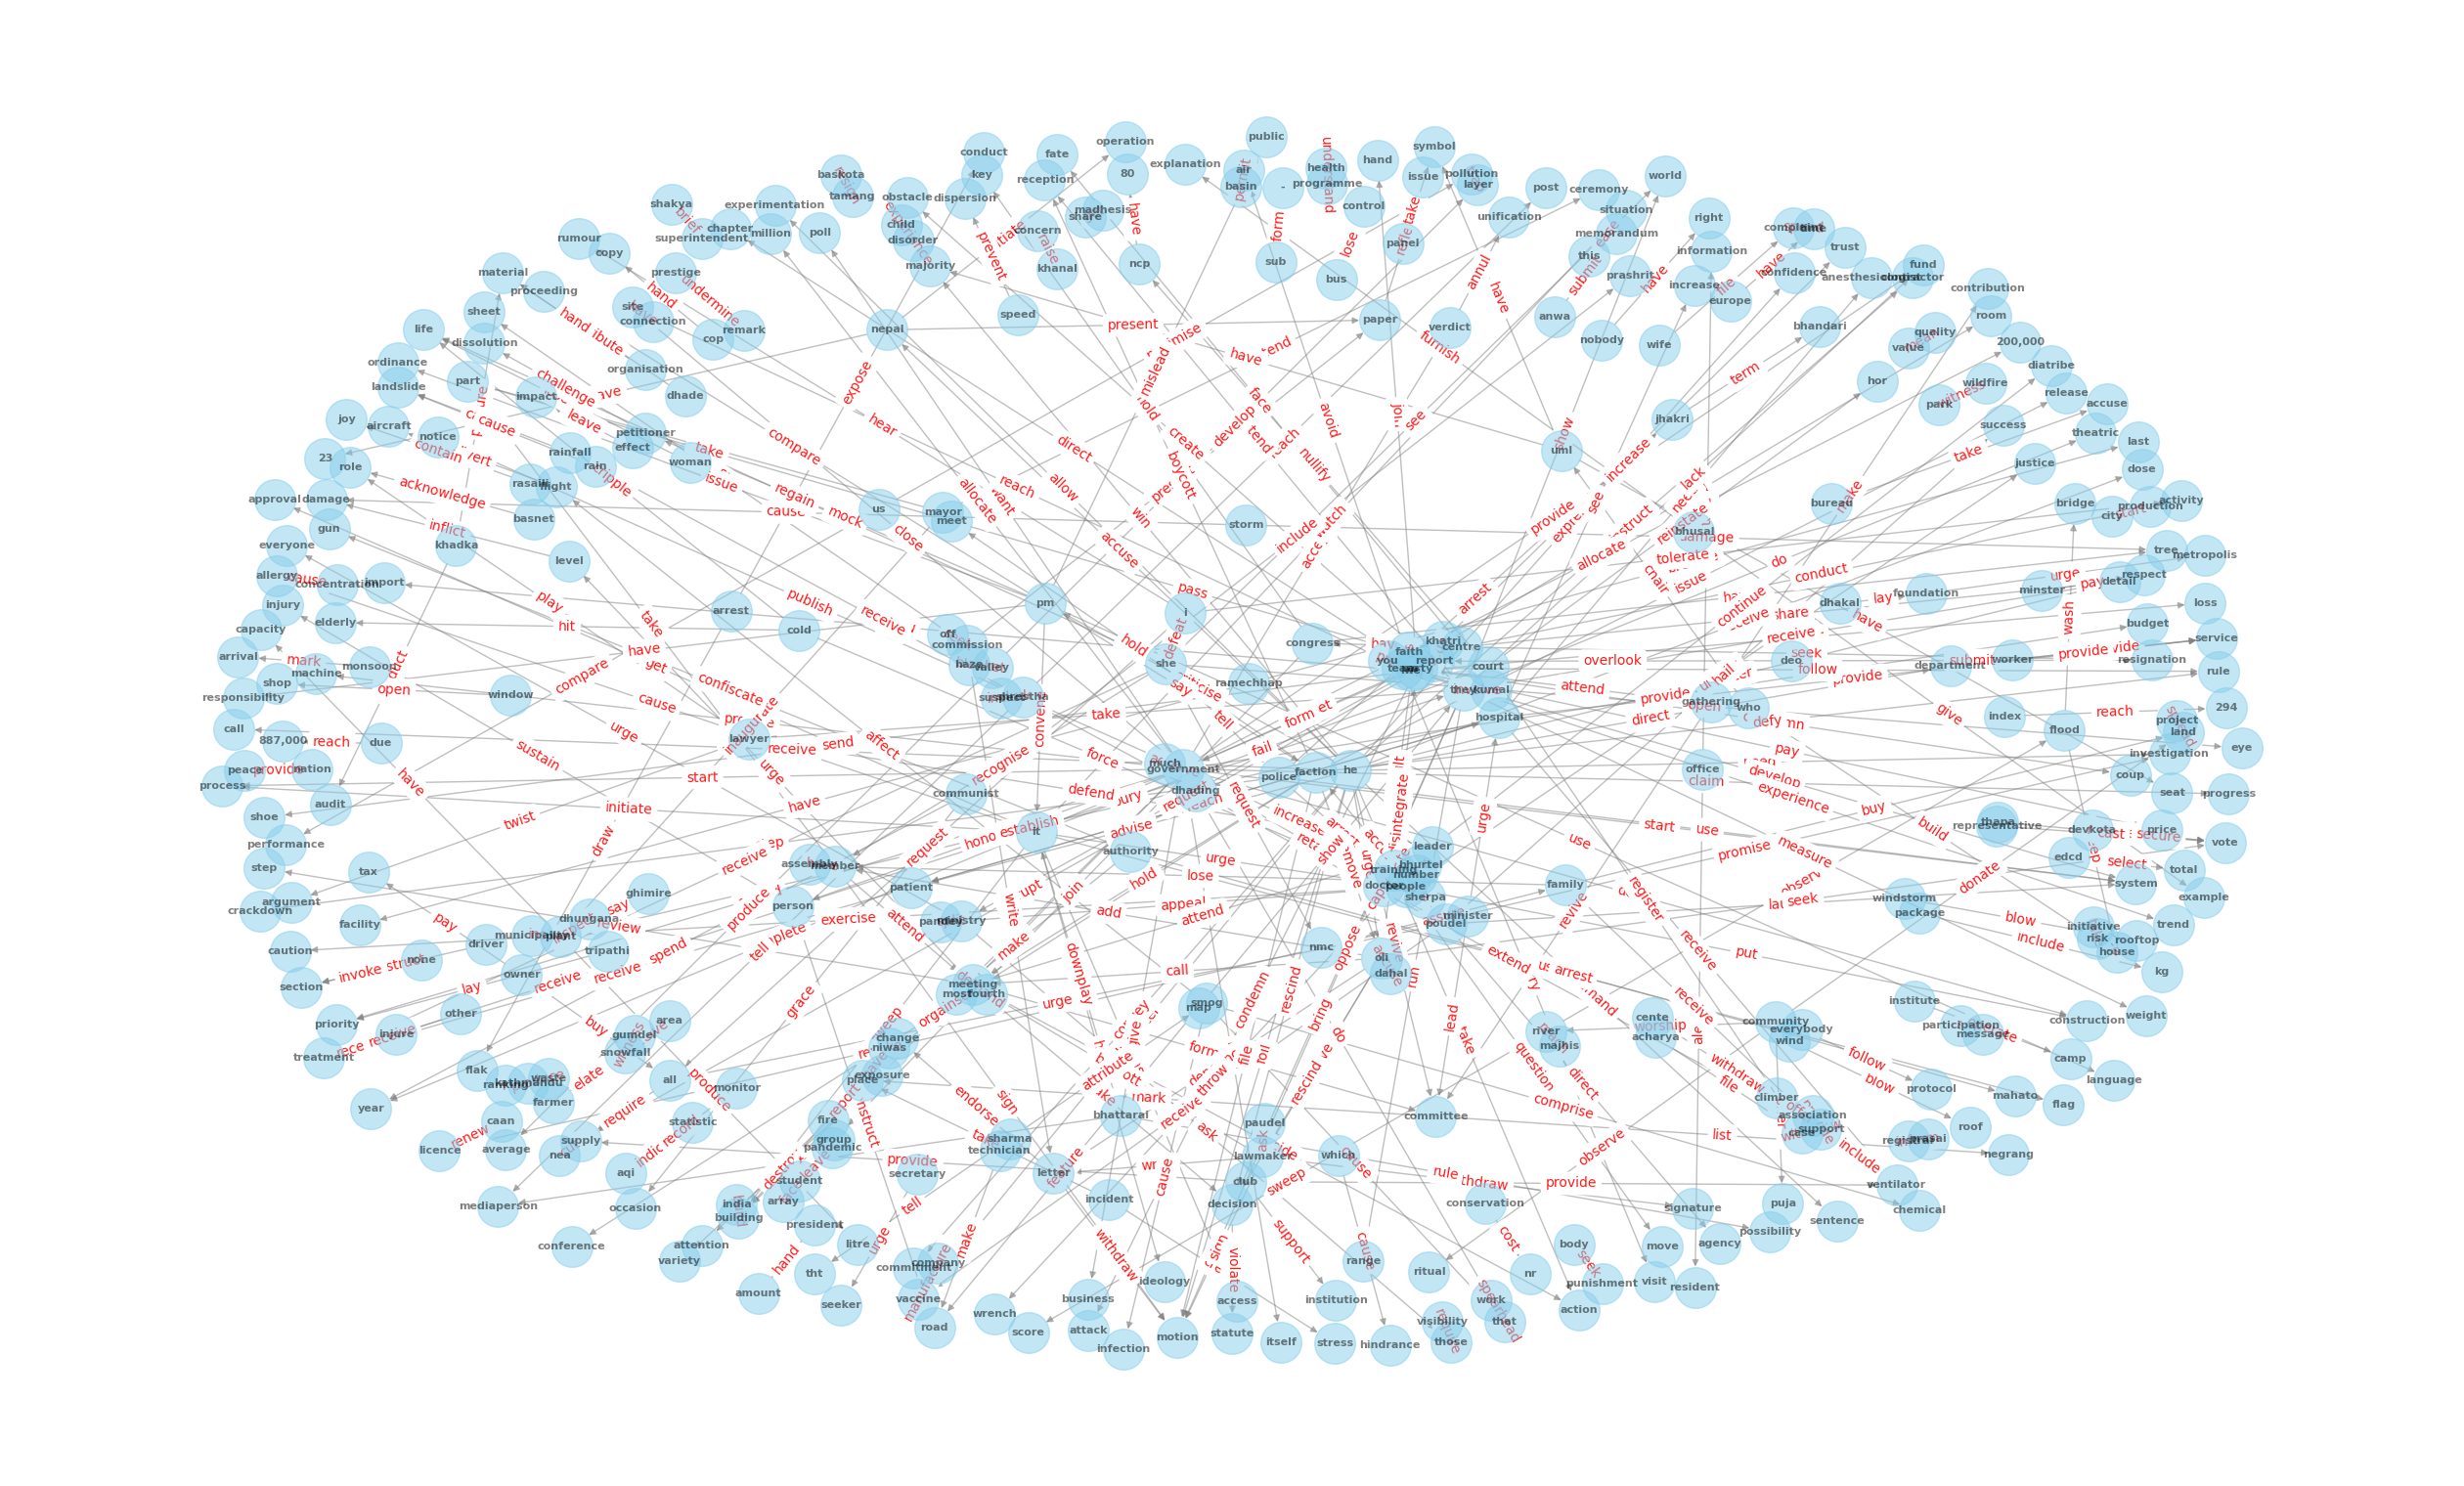

In [14]:
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(25, 15))
nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=900, node_color='skyblue', font_size=8, edge_color='gray', alpha = 0.5)
edge_labels = {(n1, n2): G[n1][n2]['label'] for (n1, n2) in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', alpha=0.9)
plt.show()

In [16]:
file_name = 'data/bagmati_articles.gz'

nx.write_graphml(G, file_name)